## Importamos las librerías

In [133]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

### Cargamos csv

In [98]:
df = pd.read_csv("Libro2.csv", sep=';', encoding='latin1')

### Comenzamos EDA

**Hacemos un análisis de las columnas.**

In [99]:
df.head()

,Perfume,Brand,Gender,Middle,Base,mainaccord1,mainaccord2,mainaccord3,mainaccord4,mainaccord5
0,accento-overdose-pride-edition,xerjoff,unisex,"bulgarian rose, egyptian jasmine, lily-of-the-...","eucalyptus, pine",rose,woody,fruity,aromatic,floral
1,classique-pride-2024,jean-paul-gaultier,women,"orange blossom, neroli","musk, blonde woods",citrus,white floral,sweet,fresh,musky
2,classique-pride-2023,jean-paul-gaultier,unisex,"neroli, orange blossom","musk, white woods",citrus,white floral,sweet,fresh spicy,musky
3,le-male-pride-collector,jean-paul-gaultier,men,"caraway, cinnamon, orange blossom","vanilla, sandalwood, amber, cedar, tonka bean",aromatic,warm spicy,fresh spicy,cinnamon,vanilla
4,le-male-pride-2023,jean-paul-gaultier,men,"neroli, orange blossom","musk, white woods",citrus,white floral,sweet,fresh spicy,green


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7499 entries, 0 to 7498
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Perfume      7499 non-null   object
 1   Brand        7499 non-null   object
 2   Gender       7499 non-null   object
 3   Middle       7499 non-null   object
 4   Base         7499 non-null   object
 5   mainaccord1  7499 non-null   object
 6   mainaccord2  7497 non-null   object
 7   mainaccord3  7459 non-null   object
 8   mainaccord4  7389 non-null   object
 9   mainaccord5  7223 non-null   object
dtypes: object(10)
memory usage: 586.0+ KB


Vemos que todas las columnas tiene valores de tipo 'objeto', a continuación comprobaremos los valores nulos.

In [101]:
df.isnull().sum()

Perfume          0
Brand            0
Gender           0
Middle           0
Base             0
mainaccord1      0
mainaccord2      2
mainaccord3     40
mainaccord4    110
mainaccord5    276
dtype: int64

Hay algunos valores nulos en los últimos acordes; para posteriormente hacer PCAs es necesario que no haya valores nulos, por lo que a estos imputaremos valores.

A la hora de imputar los valores imputar con valores como la mediana podría dar problemas en el anális posterior ya que este valor sería el de un aroma, lo que podría adulterar los datos sobre cada perfume, por lo que les daaremos el valor 'none' para que tras su posterior codificación tengan todos los valores nulos le mismo valor codificado.

In [102]:
df['mainaccord1'] = df['mainaccord1'].fillna('none')
df['mainaccord2'] = df['mainaccord2'].fillna('none')
df['mainaccord3'] = df['mainaccord3'].fillna('none')
df['mainaccord4'] = df['mainaccord4'].fillna('none')
df['mainaccord5'] = df['mainaccord5'].fillna('none')

Definimos las columnas mainaccord y las guardamos en main_cols:

In [103]:
main_cols = [c for c in df.columns if c.startswith('mainaccord')]
print("Columnas detectadas:", main_cols)

Columnas detectadas: ['mainaccord1', 'mainaccord2', 'mainaccord3', 'mainaccord4', 'mainaccord5']


Codificamos las columnas aplicando la misma condición a todas las columnas, si en la columna 1 el aroma 'x' tiene valor 1, en el resto de columnas también lo será.

In [ ]:

ordered = []
for c in main_cols:
    for v in df[c].dropna().astype(str):
        if v not in ordered:
            ordered.append(v)

mapping = {v: i for i, v in enumerate(ordered, start=1)}  
print("Número de categorías encontradas:", len(mapping))
print("Ejemplo de mapping (primeros 10):", dict(list(mapping.items())[:10]))

for c in main_cols:
    df[c] = df[c].map(mapping)


Número de categorías encontradas: 73
Ejemplo de mapping (primeros 10): {'rose': 1, 'citrus': 2, 'aromatic': 3, 'white floral': 4, 'woody': 5, 'powdery': 6, 'leather': 7, 'floral': 8, 'ozonic': 9, 'warm spicy': 10}


Eliminamos las columnas 'middle' y 'base' ya que para aún no vamos a usarlas

In [105]:
df.drop(columns=['middle', 'base'], inplace=True, errors='ignore')

En el histograma podemos ver que los primeros aromas son los mas repetidos, este patrón se repite en todas las columnas menos en la última, donde el aroma n65 tiene también gran importancia.

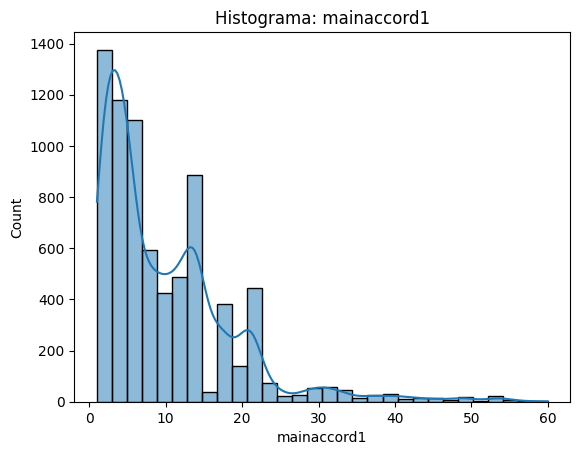

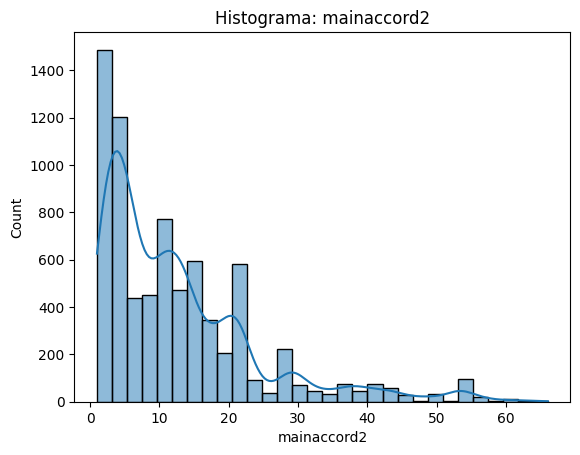

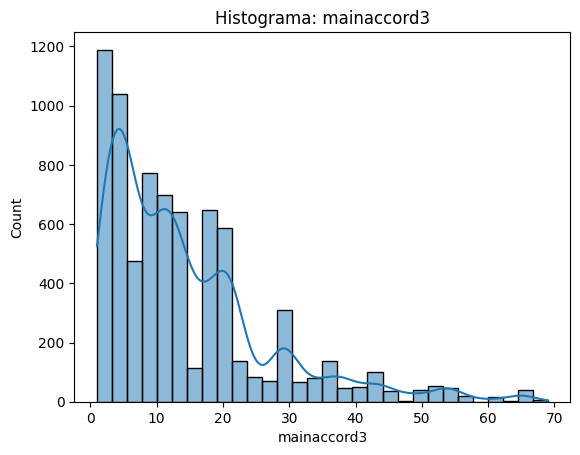

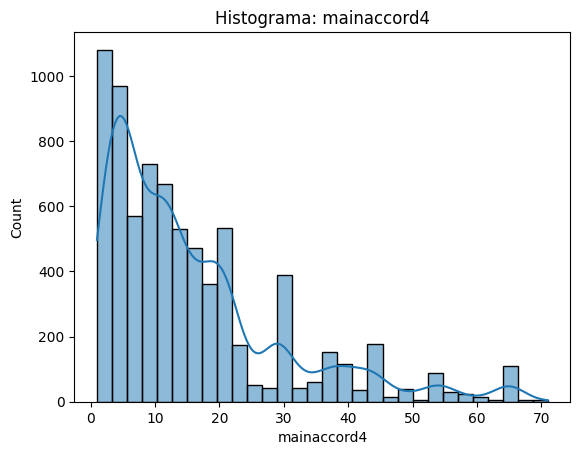

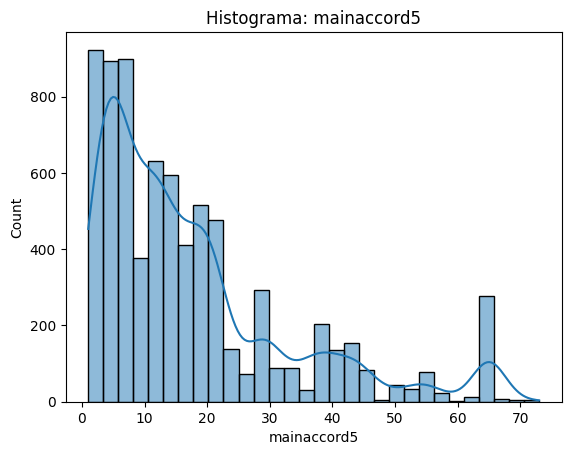

In [106]:
if "num_df" not in globals():
    num_df = df.select_dtypes(include=[np.number])
for col in num_df.columns:
    sns.histplot(df[col].dropna(), bins=30, kde=True)
    plt.title(f'Histograma: {col}')
    plt.show()

**Matriz de correlación**

In [ ]:
num_df = df.select_dtypes(include=[np.number])
corr = num_df.corr()
corr

,mainaccord1,mainaccord2,mainaccord3,mainaccord4,mainaccord5
mainaccord1,1.000000,0.075841,0.002409,0.026412,-0.002360
mainaccord2,0.075841,1.000000,0.024118,0.022198,0.014081
mainaccord3,0.002409,0.024118,1.000000,0.058996,0.047249
mainaccord4,0.026412,0.022198,0.058996,1.000000,0.140241
mainaccord5,-0.002360,0.014081,0.047249,0.140241,1.000000


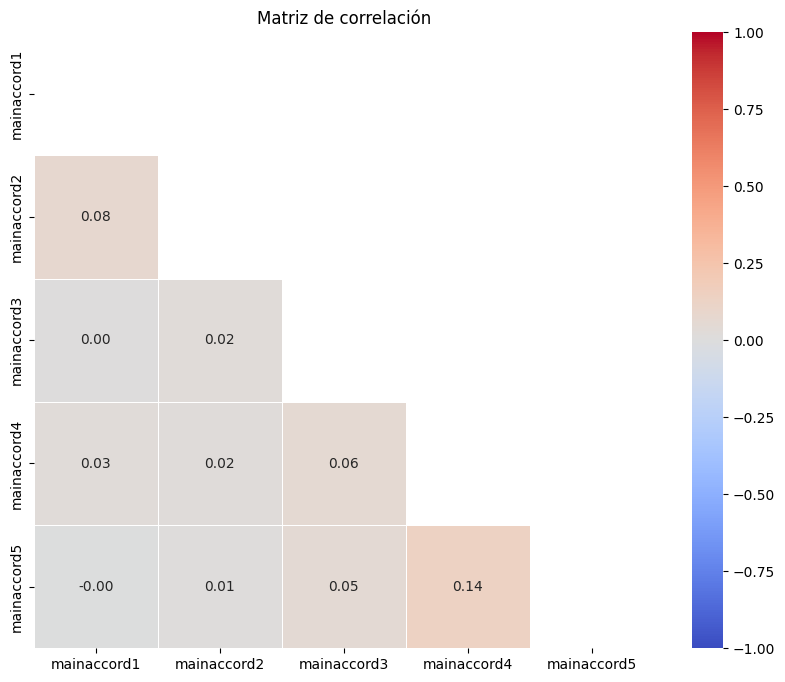

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))  # opcional: ocultar triángulo superior
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            vmin=-1, vmax=1, linewidths=.5)
plt.title("Matriz de correlación")
plt.show()

Se puede ver que las columnas no tienen gran correlación entre si. Esto no tiene porque ser excluyente de realizar una correcta predicción como comprobaremos posteriormente.

**PCA**

Definimos las features para el PCA:

In [109]:
features = ["mainaccord1","mainaccord2","mainaccord3","mainaccord4","mainaccord5"]
X = df[features].copy()


Normalizamos los datos: 

In [111]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Queremos encontrar la cantidad justa de PCAs para explicar un 80%-90% de la varianza.

In [ ]:
pca = PCA(n_components=4, random_state=0)
pcs = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(pcs, columns=["PC1","PC2","PC3","PC4"], index=X.index)
# add the imputed feature columns so they match the PCA input
for col in features:
	pca_df[col] = X[col].values

pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum()

(array([0.23699878, 0.21323753, 0.19403807, 0.1845456 ]),
 np.float64(0.8288199834804488))

Finalmente usaremos 4 componentes

In [115]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=features,
    columns=["PC1","PC2","PC3","PC4"]
)
loadings


,PC1,PC2,PC3,PC4
mainaccord1,0.189803,0.687560,-0.203621,-0.648383
mainaccord2,0.249345,0.648873,0.129930,0.704532
mainaccord3,0.387986,-0.075536,0.887298,-0.224900
mainaccord4,0.631124,-0.157890,-0.251201,-0.091679
mainaccord5,0.594097,-0.274936,-0.302087,0.155719


Realizamos una matriz para analizar que componentes afectan mas a cada aroma.

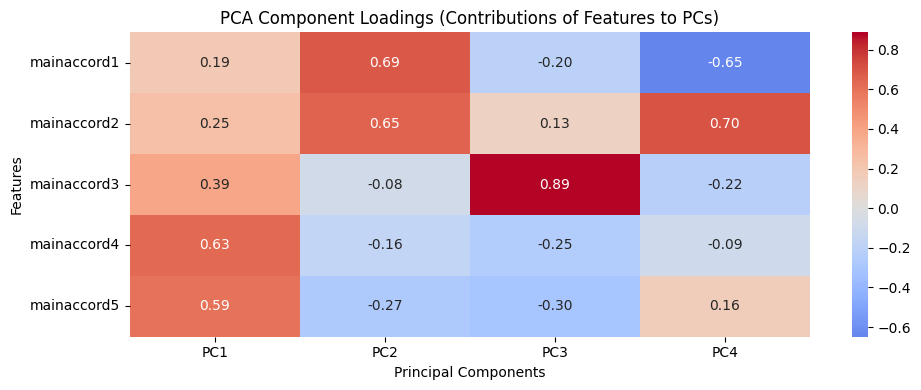

In [135]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=features,
    columns=[f"PC{i}" for i in range(1, pca.n_components_ + 1)]
)

plt.figure(figsize=(10, 4))
sns.heatmap(
    loadings,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("PCA Component Loadings (Contributions of Features to PCs)")
plt.ylabel("Features")
plt.xlabel("Principal Components")
plt.tight_layout()
plt.show()


Podemos ver en la matriz que el PC1 tiene gran influencia en los últimos acordes, mientras que la columna PC2 afecta principalmente los primeros acordes. La tercera columna influye sobre el 3 acorde principalmente y la última columna (PC4) tiene gran influencia positiva y negativa en los 2 primeros acordes afectando tamvién al resto de acordes levemente.

**Fin del EDA**

**Comienzo de la predicción**

In [136]:
import tensorflow as tf
from tensorflow.keras import layers, models

def crear_modelo_perfume(n_perfumes):
    user_input = layers.Input(shape=(4,), name="User_Preferences")
    
    perfume_input = layers.Input(shape=(4,), name="Perfume_Features")
    
    combined = layers.Concatenate()([user_input, perfume_input])
    
    # Capas densas para aprender la relación (Regresión)
    x = layers.Dense(32, activation='relu')(combined)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dense(8, activation='relu')(x)
    
    
    output = layers.Dense(1, activation='sigmoid', name="Score")(x)
    
    model = models.Model(inputs=[user_input, perfume_input], outputs=output)
    model.compile(optimizer='adam', loss='mse') # Mean Squared Error para regresión
    return model

In [137]:
# Preparamos el dataset final para la red
final_dataset = pca_df[['PC1', 'PC2', 'PC3', 'PC4']].copy()
final_dataset['perfume_id'] = range(len(final_dataset))
final_dataset['name'] = df['Perfume']

print("Dataset listo para la red neuronal:")
print(final_dataset.head())

Dataset listo para la red neuronal:
        PC1       PC2       PC3       PC4  perfume_id  \
0 -1.303424 -0.815326  0.503552  0.179370           0   
1  0.497872 -1.320174  0.293943 -0.144848           1   
2 -0.311491 -1.117693  0.616087 -0.027278           2   
3  1.387033 -1.085566 -0.785292  0.150281           3   
4 -0.537039 -1.013314  0.730774 -0.086396           4   

                             name  
0  accento-overdose-pride-edition  
1            classique-pride-2024  
2            classique-pride-2023  
3         le-male-pride-collector  
4              le-male-pride-2023  


In [138]:
import numpy as np

def generar_datos_entrenamiento(pca_data, n_ejemplos=20000):
    # Generamos preferencias de usuarios aleatorias (-3 a 3 para cubrir el rango del PCA)
    user_prefs = np.random.uniform(-3, 3, (n_ejemplos, 4))
    
    # Seleccionamos perfumes aleatorios del dataset para cada usuario ficticio
    indices_perfumes = np.random.choice(len(pca_data), n_ejemplos)
    perfume_features = pca_data.iloc[indices_perfumes].values
    
    # Calculamos el 'score' usando la similitud del coseno (la "verdad" que la red debe aprender)
    # Esto da un valor entre 0 (odio) y 1 (amor)
    from sklearn.metrics.pairwise import cosine_similarity
    
    # Simplificado: un producto escalar normalizado para simular afinidad
    scores = np.sum(user_prefs * perfume_features, axis=1)
    scores = (scores - scores.min()) / (scores.max() - scores.min()) # Normalizar a [0, 1]
    
    return [user_prefs, perfume_features], scores

# Generamos los datos
[X_user, X_perfume], y_scores = generar_datos_entrenamiento(pca_df[['PC1', 'PC2', 'PC3', 'PC4']])

In [139]:
# Creamos y entrenamos el modelo que definiste antes
# Asegúrate de crear el modelo antes de llamar a fit
model = crear_modelo_perfume(n_perfumes=final_dataset.shape[0])

history = model.fit(
    [X_user, X_perfume], y_scores,
    epochs=20,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0046 - val_loss: 0.0011
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.4590e-04 - val_loss: 5.3890e-04
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.3117e-04 - val_loss: 4.3568e-04
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.8539e-04 - val_loss: 3.5131e-04
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2836e-04 - val_loss: 3.1642e-04
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.8970e-04 - val_loss: 2.7418e-04
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.4969e-04 - val_loss: 2.3802e-04
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2825e-04 - val_loss: 2.1384e-04
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.9009e-04 - val_loss: 1.9576e-04
Epoch 10/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7108e-04 - val_loss: 1.7324e-04
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4973

In [124]:
def recomendar_perfumes(mis_preferencias, pca_data, original_df, top_n=5):
    # Preparamos el vector del usuario (repetido para comparar con todos los perfumes)
    user_input = np.tile(mis_preferencias, (len(pca_data), 1))
    perfume_input = pca_data[['PC1', 'PC2', 'PC3', 'PC4']].values
    
    # La red predice el score para todos a la vez
    scores = model.predict([user_input, perfume_input])
    
    # Añadimos los scores al dataframe original para ver nombres
    resultados = original_df.copy()
    resultados['match_score'] = scores
    
    return resultados.sort_values(by='match_score', ascending=False).head(top_n)

In [125]:
# Ejemplo: Me gusta mucho lo limpio (2) y lo intenso (2), pero odio lo cálido (-2)
mis_gustos = np.array([2.0, -2.0, 0.5, 2.0]) 

top_recomendaciones = recomendar_perfumes(mis_gustos, pca_df, df)
print(top_recomendaciones[['Perfume', 'Brand', 'match_score']]) 

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
                                               Perfume               Brand  \
1665                                       gucci-bloom               gucci   
5862  acqua-di-parma-blu-mediterraneo-arancia-di-capri      acqua-di-parma   
4371                           vibrant-leather-intense                zara   
2460        eau-de-lacoste-l-12-12-pour-elle-sparkling  lacoste-fragrances   
2123                           tropical-splash-kumquat         marc-jacobs   

      match_score  
1665     0.802087  
5862     0.801869  
4371     0.801235  
2460     0.782330  
2123     0.778970  


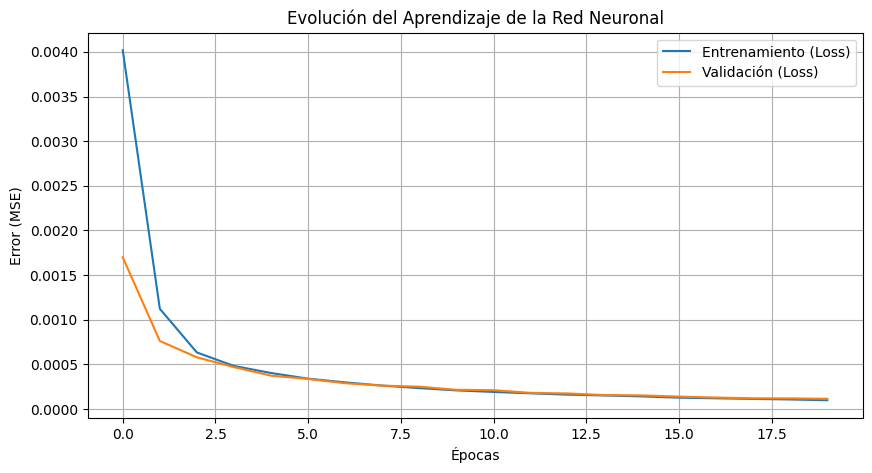

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Entrenamiento (Loss)')
plt.plot(history.history['val_loss'], label='Validación (Loss)')
plt.title('Evolución del Aprendizaje de la Red Neuronal')
plt.xlabel('Épocas')
plt.ylabel('Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

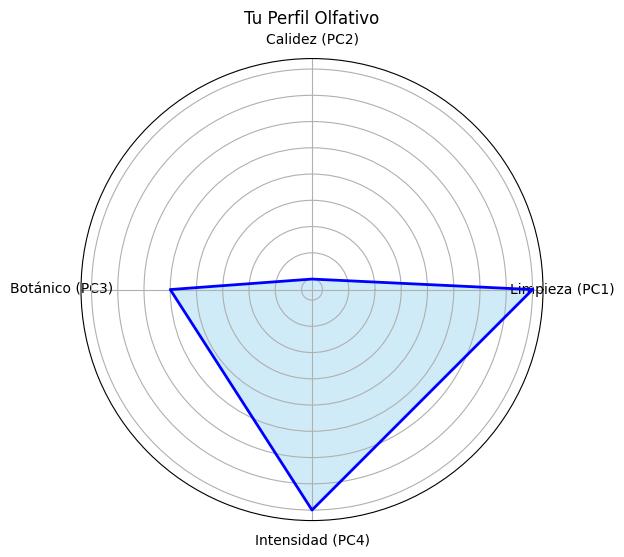

In [127]:
import numpy as np

def graficar_perfil_usuario(gustos):
    labels = ['Limpieza (PC1)', 'Calidez (PC2)', 'Botánico (PC3)', 'Intensidad (PC4)']
    # Cerramos el gráfico circular
    stats = np.concatenate((gustos, [gustos[0]]))
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.fill(angles, stats, color='skyblue', alpha=0.4)
    ax.plot(angles, stats, color='blue', linewidth=2)
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    plt.title("Tu Perfil Olfativo")
    plt.show()

# Ejemplo con tus gustos anteriores
graficar_perfil_usuario(mis_gustos)

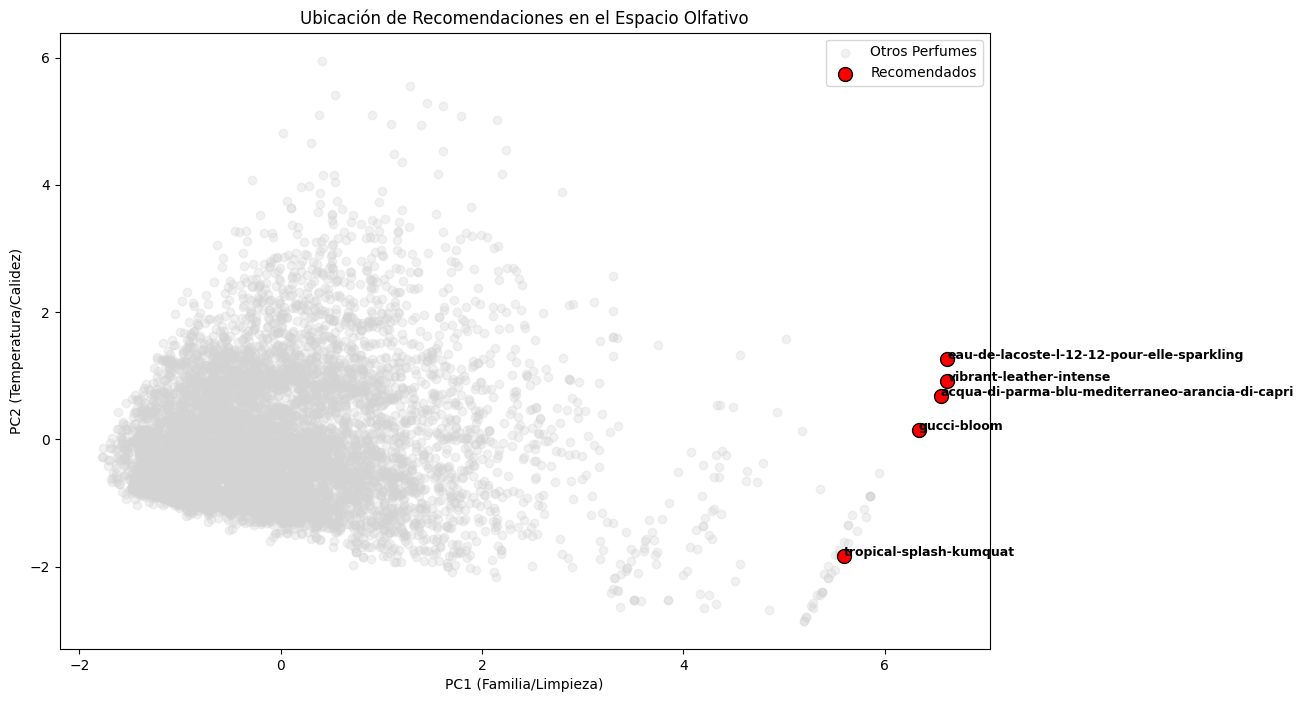

In [128]:
def graficar_recomendaciones(pca_df, recomendados_df):
    plt.figure(figsize=(12, 8))
    
    # Todos los perfumes de fondo
    plt.scatter(pca_df['PC1'], pca_df['PC2'], c='lightgrey', alpha=0.3, label='Otros Perfumes')
    
    # Resaltar los recomendados
    recom_pca = pca_df.loc[recomendados_df.index]
    plt.scatter(recom_pca['PC1'], recom_pca['PC2'], c='red', s=100, edgecolors='black', label='Recomendados')
    
    # Etiquetas de nombres
    for i, txt in enumerate(recomendados_df['Perfume']):
        plt.annotate(txt, (recom_pca['PC1'].iloc[i], recom_pca['PC2'].iloc[i]), fontsize=9, fontweight='bold')
        
    plt.xlabel('PC1 (Familia/Limpieza)')
    plt.ylabel('PC2 (Temperatura/Calidez)')
    plt.title('Ubicación de Recomendaciones en el Espacio Olfativo')
    plt.legend()
    plt.show()

graficar_recomendaciones(pca_df, top_recomendaciones)

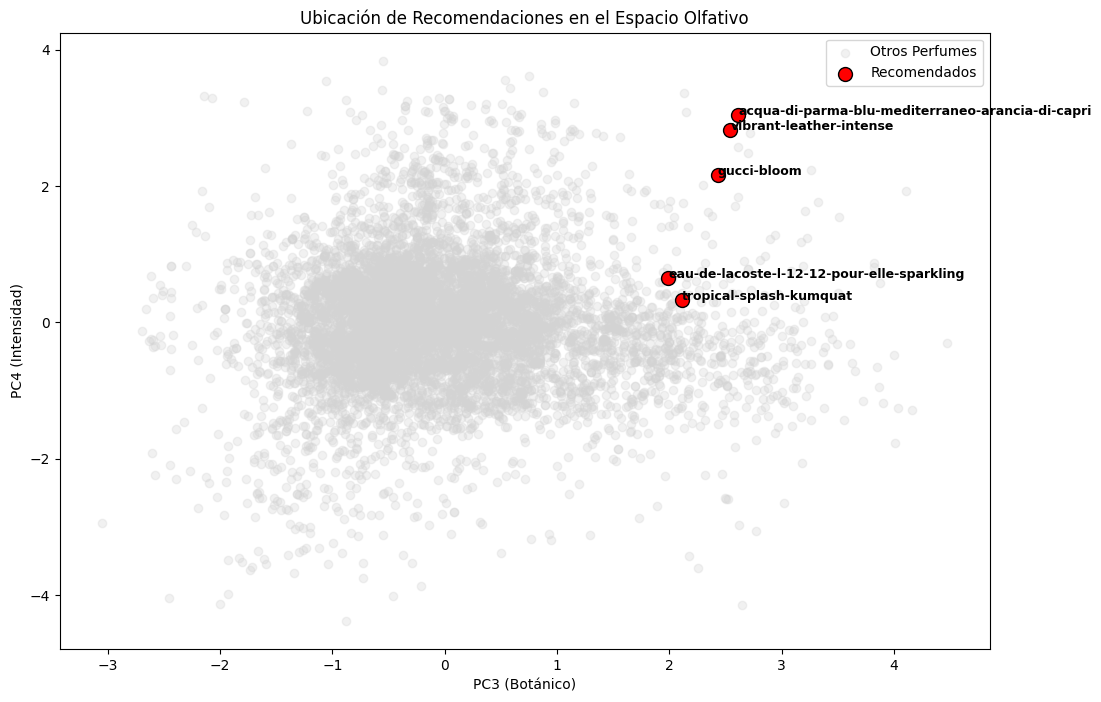

In [129]:
def graficar_recomendaciones(pca_df, recomendados_df):
    plt.figure(figsize=(12, 8))
    
    # Todos los perfumes de fondo
    plt.scatter(pca_df['PC3'], pca_df['PC4'], c='lightgrey', alpha=0.3, label='Otros Perfumes')
    
    # Resaltar los recomendados
    recom_pca = pca_df.loc[recomendados_df.index]
    plt.scatter(recom_pca['PC3'], recom_pca['PC4'], c='red', s=100, edgecolors='black', label='Recomendados')
    
    # Etiquetas de nombres
    for i, txt in enumerate(recomendados_df['Perfume']):
        plt.annotate(txt, (recom_pca['PC3'].iloc[i], recom_pca['PC4'].iloc[i]), fontsize=9, fontweight='bold')
        
    plt.xlabel('PC3 (Botánico)')
    plt.ylabel('PC4 (Intensidad)')
    plt.title('Ubicación de Recomendaciones en el Espacio Olfativo')
    plt.legend()
    plt.show()

graficar_recomendaciones(pca_df, top_recomendaciones)

In [130]:
def recomendar_con_filtro(mis_preferencias, pca_data, original_df, genero=None, top_n=5):
    # Copia de los datos para no afectar el original
    df_temp = original_df.copy()
    pca_temp = pca_data.copy()
    
    # Aplicar filtro de género si se solicita
    if genero:
        mask = df_temp['Gender'].isin(genero)
        df_temp = df_temp[mask]
        pca_temp = pca_temp[mask]
    
    # Preparar entrada para la red neuronal
    user_input = np.tile(mis_preferencias, (len(pca_temp), 1))
    perfume_input = pca_temp[['PC1', 'PC2', 'PC3', 'PC4']].values
    
    # Predicción
    scores = model.predict([user_input, perfume_input])
    df_temp['match_score'] = scores
    
    return df_temp.sort_values(by='match_score', ascending=False).head(top_n)

# Ejemplo de uso: Buscamos perfumes de Hombre o Unisex
mis_gustos = np.array([1.5, -0.5, 2.0, 1.0]) # Tu perfil
rec = recomendar_con_filtro(mis_gustos, pca_df, df, genero=['men', 'unisex'])
print(rec[['Perfume', 'Brand', 'Gender', 'match_score']])

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
                                               Perfume            Brand  \
5862  acqua-di-parma-blu-mediterraneo-arancia-di-capri   acqua-di-parma   
4371                           vibrant-leather-intense             zara   
1815                                              yuzu          j-scent   
5824                                   orange-sanguine  atelier-cologne   
2222                         marc-jacobs-splash-orange      marc-jacobs   

      Gender  match_score  
5862  unisex     0.763895  
4371     men     0.762343  
1815  unisex     0.752695  
5824  unisex     0.752695  
2222     men     0.752695  


In [131]:
# En tu Jupyter Notebook
model.save('modelo_perfumes.h5')
print("¡Modelo guardado con éxito como modelo_perfumes.h5!")

¡Modelo guardado con éxito como modelo_perfumes.h5!


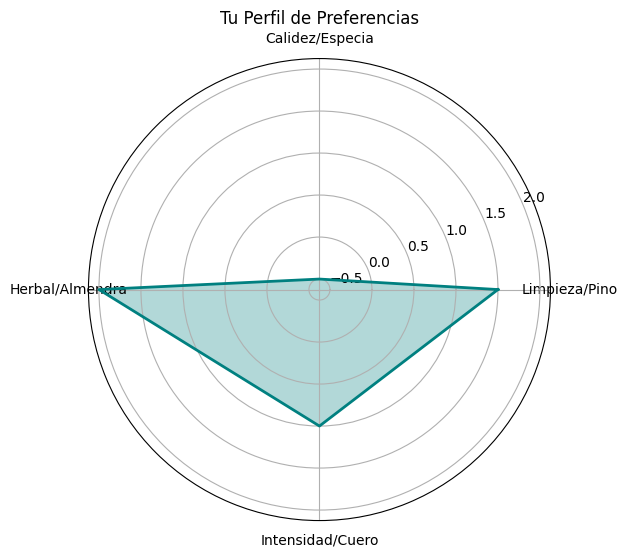

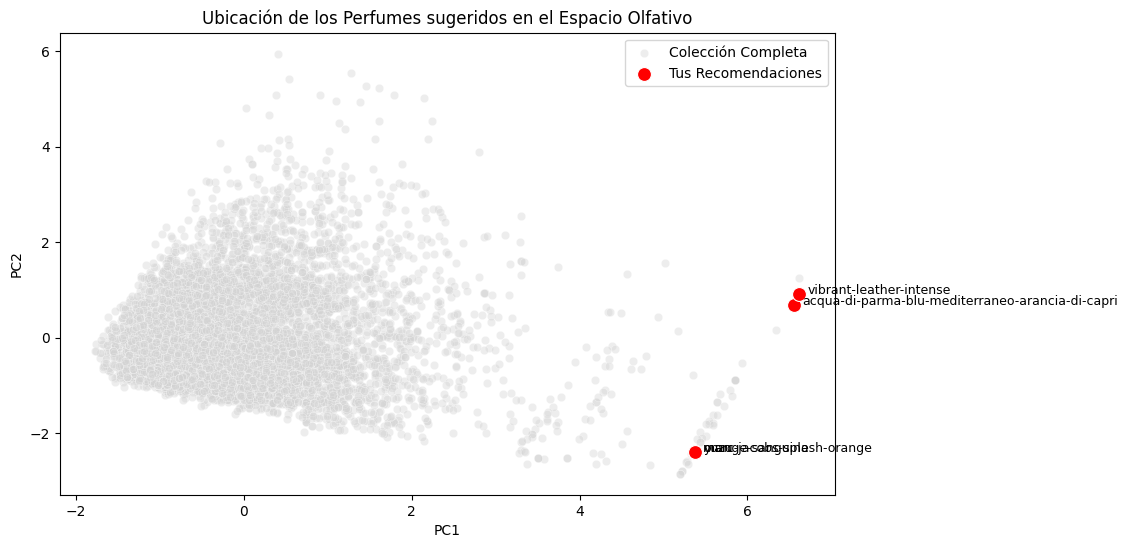

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns

# A. Gráfico de Radar (Tu huella olfativa)
def plot_radar(gustos):
    labels = ['Limpieza/Pino', 'Calidez/Especia', 'Herbal/Almendra', 'Intensidad/Cuero']
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
    # Cerramos el polígono
    gustos_plot = np.concatenate((gustos, [gustos[0]]))
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.fill(angles, gustos_plot, color='teal', alpha=0.3)
    ax.plot(angles, gustos_plot, color='teal', linewidth=2)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    plt.title("Tu Perfil de Preferencias")
    plt.show()

# B. Mapa de Posicionamiento (Dónde están tus recomendados)
def plot_mapa(pca_df, rec_df):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', color='lightgrey', alpha=0.4, label='Colección Completa')
    
    # Resaltamos los recomendados
    puntos_rec = pca_df.loc[rec_df.index]
    sns.scatterplot(x=puntos_rec['PC1'], y=puntos_rec['PC2'], color='red', s=100, label='Tus Recomendaciones')
    
    # Añadimos etiquetas
    for i, name in enumerate(rec_df['Perfume']):
        plt.text(puntos_rec['PC1'].iloc[i]+0.1, puntos_rec['PC2'].iloc[i], name, fontsize=9)
    
    plt.title("Ubicación de los Perfumes sugeridos en el Espacio Olfativo")
    plt.show()

plot_radar(mis_gustos)
plot_mapa(pca_df, rec)